# Create 2D Patch Data

* Input: box_data
* Output: 2D patch .npy file

In [1]:
import os, glob, ntpath
import numpy as np
import matplotlib.pyplot as plt
from skimage import morphology, measure
import scipy.misc

In [2]:
# Set up path and parameters
data_path = '/home/d/pancreas/new_box_data'
# data_path = '/home/u/sonic81518/pancreas/box_data'
# target_path = '/home/u/sonic81518/pancreas/test_data'
target_path = '/home/d/pancreas/patch_data/test_data'
dilation = 5
patch_size = 50
pancreas_threadshold = 800
lesion_threadshold = 300
stride = 40
normalize = True

In [35]:
# TODO: check if the size is the same

In [9]:
# Cut patches and count save to file
def cut_patch(target_path, case_id, img, lbl, patch_size, stride, threadshold):
    slice_count = 0
    for i in range(lbl.shape[2]):
        pic = img[:,:,i] * lbl[:,:,i]
        lbl_map = measure.label(lbl[:,:,i].astype(int))
        for region in measure.regionprops(lbl_map):
            if region.area > threadshold:
                slice_count = slice_count + 1
                box = region.bbox
                height = box[2] - box[0]
                width = box[3] - box[1]
                print(height, width)
                shift_count = 0
                for row in range(max((height-patch_size),0) // stride + 1):
                    for col in range(max((width-patch_size),0) // stride + 1):
                        shift_count = shift_count + 1

                        up_ref = box[0]+row*stride
                        left_ref = box[1]+col*stride
                        down_ref = min(up_ref+patch_size, box[2])
                        right_ref = min(left_ref+patch_size, box[3])

                        up = max(np.floor((patch_size - (down_ref-up_ref))/2).astype(int),0)
                        left = max(np.floor((patch_size - (right_ref-left_ref))/2).astype(int),0)
                        down = min(up+(down_ref-up_ref), patch_size)
                        right = min(left+(right_ref-left_ref), patch_size)

                        patch = np.zeros([patch_size, patch_size])
                        patch[up:down, left:right] = pic[up_ref:down_ref, left_ref:right_ref]
                        np.save(target_path+'/'+case_id+'_'+str(slice_count)+'_'+str(shift_count)+'.npy', patch)
    #                     scipy.misc.imsave(target_path+'/'+case_id+'_'+str(slice_count)+'_'+str(shift_count)+'.jpg', patch)

    print('Total slice:', samplePancreas.shape[2])
    print('Slice count:', slice_count)

In [4]:
img_list = glob.glob(data_path + '/*/ctscan.npy')

In [39]:
for img_path in img_list:
    case_id = ntpath.basename(os.path.normpath(img_path.replace('/ctscan.npy','/')))
    print('Processing data:', case_id)
    
    sampleCTimg = np.load(img_path)
    if normalize == True:
        sampleCTimg[np.where(sampleCTimg < -50)] = -50
        sampleCTimg[np.where(sampleCTimg > 200)] = 200
        sampleCTimg = sampleCTimg / (2*(np.max(sampleCTimg)-np.min(sampleCTimg))) + 0.5
    
    les_path = img_path.replace('ctscan', 'lesion')
    pan_path = img_path.replace('ctscan', 'pancreas')
    
    if os.path.isfile(les_path) and os.path.isfile(pan_path):
        sampleLesion = np.load(les_path)
        samplePancreas = np.load(pan_path)
        
        # Remove the lesion part from pancreas
        lesion_remove = morphology.dilation(sampleLesion,np.ones([dilation, dilation, dilation]))
        samplePancreas[np.where(lesion_remove==1)] = 0
        
        # Processing
        samplePancreas = morphology.erosion(samplePancreas, np.ones([3,3,3]))
        samplePancreas = morphology.dilation(samplePancreas, np.ones([3,3,3]))
        
        
        pancreas_path = target_path + '/pancreas'
        lesion_path = target_path + '/lesion'
    
        cut_patch(pancreas_path, case_id, sampleCTimg, samplePancreas, patch_size, stride, pancreas_threadshold)
        cut_patch(lesion_path, case_id, sampleCTimg, sampleLesion, patch_size, stride, lesion_threadshold)
    else:
        print('Missing file in:', case_id)
    

Processing data: PT6
Total slice: 113
Slice count: 65
Total slice: 113
Slice count: 16
Processing data: PT28
Missing file in: PT28
Processing data: PT15
Total slice: 153
Slice count: 37
Total slice: 153
Slice count: 86
Processing data: PT13
Total slice: 111
Slice count: 47
Total slice: 111
Slice count: 55
Processing data: PT14
Total slice: 144
Slice count: 59
Total slice: 144
Slice count: 75
Processing data: PT40
Total slice: 113
Slice count: 38
Total slice: 113
Slice count: 27
Processing data: PT44
Total slice: 131
Slice count: 42
Total slice: 131
Slice count: 60
Processing data: PT60
Total slice: 125
Slice count: 52
Total slice: 125
Slice count: 23
Processing data: PT26
Total slice: 102
Slice count: 45
Total slice: 102
Slice count: 17
Processing data: PT35
Total slice: 128
Slice count: 46
Total slice: 128
Slice count: 51
Processing data: PT61
Total slice: 90
Slice count: 31
Total slice: 90
Slice count: 14
Processing data: PT37
Total slice: 123
Slice count: 73
Total slice: 123
Slice c

# Version 1.1

In [13]:
# Cut patches and count save to file
def cut_patch_test(target_path, case_id, img, lbl, patch_size, threadshold):
    slice_count = 0
    for i in range(lbl.shape[2]):
        pic = img[:,:,i] * lbl[:,:,i]
        lbl_map = measure.label(lbl[:,:,i].astype(int))
        for region in measure.regionprops(lbl_map):
            if region.area > threadshold:
                slice_count = slice_count + 1
                box = region.bbox
                height = box[2] - box[0]
                width = box[3] - box[1]
                num_row = max((height-patch_size),0) // patch_size + 1
                num_col = max((width-patch_size),0) // patch_size + 1
                stride_row = int(height/num_row)
                stride_col = int(width/num_col)
                shift_count = 0
                for row in range(num_row):
                    for col in range(num_col):
                        shift_count = shift_count + 1

                        up_ref = box[0]+row*stride_row
                        left_ref = box[1]+col*stride_col
                        down_ref = min(up_ref+patch_size, box[2])
                        right_ref = min(left_ref+patch_size, box[3])

                        up = max(np.floor((patch_size - (down_ref-up_ref))/2).astype(int),0)
                        left = max(np.floor((patch_size - (right_ref-left_ref))/2).astype(int),0)
                        down = min(up+(down_ref-up_ref), patch_size)
                        right = min(left+(right_ref-left_ref), patch_size)

                        patch = np.zeros([patch_size, patch_size])
                        patch[up:down, left:right] = pic[up_ref:down_ref, left_ref:right_ref]
                        np.save(target_path+'/'+case_id+'_'+str(slice_count)+'_'+str(shift_count)+'.npy', patch)
    #                     scipy.misc.imsave(target_path+'/'+case_id+'_'+str(slice_count)+'_'+str(shift_count)+'.jpg', patch)

    print('Total slice:', samplePancreas.shape[2])
    print('Slice count:', slice_count)

In [16]:
pancreas_path = target_path + '/pancreas'
lesion_path = target_path + '/lesion'
if not os.path.exists(pancreas_path):
    os.makedirs(pancreas_path)
    
if not os.path.exists(lesion_path):
    os.makedirs(lesion_path)

for img_path in img_list:
    case_id = ntpath.basename(os.path.normpath(img_path.replace('/ctscan.npy','/')))
    print('Processing data:', case_id)
    
    sampleCTimg = np.load(img_path)
    if normalize == True:
        sampleCTimg[np.where(sampleCTimg < -50)] = -50
        sampleCTimg[np.where(sampleCTimg > 200)] = 200
        sampleCTimg = sampleCTimg / (2*(np.max(sampleCTimg)-np.min(sampleCTimg))) + 0.5
    
    les_path = img_path.replace('ctscan', 'lesion')
    pan_path = img_path.replace('ctscan', 'pancreas')
    
    if os.path.isfile(les_path) and os.path.isfile(pan_path):
        sampleLesion = np.load(les_path)
        samplePancreas = np.load(pan_path)
        
        # Remove the lesion part from pancreas
        lesion_remove = morphology.dilation(sampleLesion,np.ones([dilation, dilation, dilation]))
        samplePancreas[np.where(lesion_remove==1)] = 0
        
        # Processing
        samplePancreas = morphology.erosion(samplePancreas, np.ones([3,3,3]))
        samplePancreas = morphology.dilation(samplePancreas, np.ones([3,3,3]))
        
        

    
        cut_patch_test(pancreas_path, case_id, sampleCTimg, samplePancreas, patch_size, pancreas_threadshold)
        cut_patch_test(lesion_path, case_id, sampleCTimg, sampleLesion, patch_size, lesion_threadshold)
    elif os.path.isfile(les_path): 
        print('Special case in:', case_id)
        sampleLesion = np.load(les_path)
        samplePancreas = np.zeros(sampleLesion.shape)

        
        cut_patch_test(pancreas_path, case_id, sampleCTimg, samplePancreas, patch_size, pancreas_threadshold)
        cut_patch_test(lesion_path, case_id, sampleCTimg, sampleLesion, patch_size, lesion_threadshold)
    else:
        print('Missing file in:', case_id)

Processing data: PT29
Special case in: PT29
Total slice: 110
Slice count: 0
Total slice: 110
Slice count: 70
Processing data: PT63
Total slice: 99
Slice count: 22
Total slice: 99
Slice count: 41
Processing data: NP3
Missing file in: NP3
Processing data: PT10
Total slice: 118
Slice count: 24
Total slice: 118
Slice count: 38
Processing data: PT4
Special case in: PT4
Total slice: 117
Slice count: 0
Total slice: 117
Slice count: 78
Processing data: PT23
Total slice: 111
Slice count: 52
Total slice: 111
Slice count: 0
Processing data: PT51
Total slice: 116
Slice count: 64
Total slice: 116
Slice count: 44
Processing data: PT13
Total slice: 111
Slice count: 47
Total slice: 111
Slice count: 55
Processing data: PT44
Total slice: 131
Slice count: 42
Total slice: 131
Slice count: 60
Processing data: NP11
Missing file in: NP11
Processing data: PT2
Total slice: 117
Slice count: 44
Total slice: 117
Slice count: 29
Processing data: PT8
Total slice: 141
Slice count: 87
Total slice: 141
Slice count: 13

In [12]:
int(np.ceil(102/50))

3

# Version 2

In [117]:
# Set up path and parameters
data_path = '/home/d/pancreas/box_data'
# data_path = '/home/u/sonic81518/project/pancreas/box_data'
target_path = '/home/u/sonic81518/project/pancreas/patch_data'
# target_path = '/home/d/pancreas/patch_data/p50ts40nor/train'
dilation = 5
patch_size = 50
pancreas_threadshold = 1800
lesion_threadshold = 1300
stride = 30
normalize = True

In [69]:
img_list = glob.glob(data_path + '/*/ctscan.npy')
img_path = img_list[0]

In [70]:
case_id = ntpath.basename(os.path.normpath(img_path.replace('/ctscan.npy','/')))


PT6


In [71]:
# Load image data
sampleCTimg = np.load(img_path)
# Windowing and normalization
sampleCTimg = np.clip(sampleCTimg, -150, 250)
img_min, img_max = sampleCTimg.min(), sampleCTimg.max()
sampleCTimg = sampleCTimg - img_min
sampleCTimg = sampleCTimg / (img_max - img_min)

In [72]:
les_path = img_path.replace('ctscan', 'lesion')
pan_path = img_path.replace('ctscan', 'pancreas')


True

In [73]:
sampleLesion = np.load(les_path)
samplePancreas = np.load(pan_path)

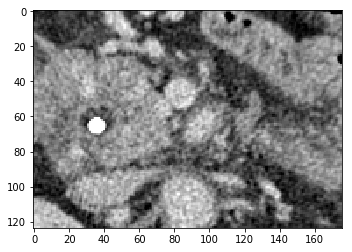

In [81]:
plt.imshow(sampleCTimg[:,:,50].T, cmap = 'gray')

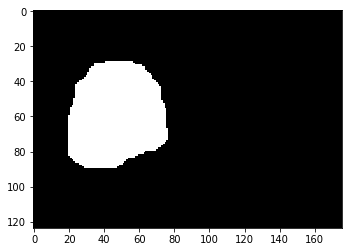

In [82]:
plt.imshow(samplePancreas[:,:,50].T, cmap = 'gray')

In [84]:
samplePancreas[np.where(sampleLesion==1)] = 0

In [115]:
def cut_patch_v2(target_path, case_id, sampleCTimg, sampleLesion, samplePancreas, patch_size, stride, lesion_threadshold, pancreas_threadshold):
    img_shape = sampleCTimg.shape
    slice_count = 0
    for z in range(img_shape[2]):
        Pancreas_shift_count = 0
        Lesion_shift_count = 0
        slice_count += 1
        for row in range(max((img_shape[0]-patch_size),0) // stride + 1):
            for col in range(max((img_shape[1]-patch_size),0) // stride + 1):
                pancreas_path = target_path + '/pancreas'
                if not os.path.exists(pancreas_path):
                    os.makedirs(pancreas_path)
                lesion_path = target_path + '/lesion'
                if not os.path.exists(lesion_path):
                    os.makedirs(lesion_path)
                up = row * stride
                left = col * stride
                down = min(up+patch_size, img_shape[0])
                right = min(left+patch_size, img_shape[1])

                v_Lesion = np.sum(sampleLesion[up:down, left:right, z])
                v_Pancreas = np.sum(samplePancreas[up:down, left:right, z])

                patch = np.zeros([patch_size, patch_size])
                if v_Lesion == 0:
                    if v_Pancreas > pancreas_threadshold:
                        Pancreas_shift_count += 1
                        patch = sampleCTimg[up:down, left:right, z]
                        np.save(pancreas_path+'/'+case_id+'_'+str(slice_count)+'_'+str(Pancreas_shift_count)+'.npy', patch)    
                else:
                    if v_Lesion > lesion_threadshold:
                        Lesion_shift_count += 1
                        patch = sampleCTimg[up:down, left:right, z]
                        np.save(lesion_path+'/'+case_id+'_'+str(slice_count)+'_'+str(Lesion_shift_count)+'.npy', patch)    
#     print('Total slice:', img_shape[2])
#     print('Slice count:', slice_count)

In [118]:
for img_path in glob.glob(data_path + '/*/ctscan.npy'):
    les_path = img_path.replace('ctscan', 'lesion')
    pan_path = img_path.replace('ctscan', 'pancreas')
    
    if os.path.isfile(les_path) and os.path.isfile(pan_path):
        
        case_id = ntpath.basename(os.path.normpath(img_path.replace('/ctscan.npy','/')))
    
        # Load image data
        sampleCTimg = np.load(img_path)
        # Windowing and normalization
        sampleCTimg = np.clip(sampleCTimg, -150, 250)
        img_min, img_max = sampleCTimg.min(), sampleCTimg.max()
        sampleCTimg = sampleCTimg - img_min
        sampleCTimg = sampleCTimg / (img_max - img_min)
        
        sampleLesion = np.load(les_path)
        samplePancreas = np.load(pan_path)
        
        cut_patch_v2(target_path, case_id, sampleCTimg, sampleLesion, samplePancreas, patch_size, stride, lesion_threadshold, pancreas_threadshold)
        

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
46.0
421.0
169.0
0.0
43.0
291.0
91.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
162.0
450.0
86.0
0.0
144.0
341.0
39.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
137.0
42.0
0.0
0.0
100.0
30.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
36.0
747.0
558.0
0.0
96.0
1590.0
1414.0
36.0
42.0
766.0
788.0
36.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
804.0
664.0
0.0
18.0
1495.0
1494.0
69.0
11.0
645.0
824.0
91.0
0.0
0.0
0.0
0.0
0.0
57.0
37.0
0.0
0.0
860.0
752.0
5.0
0.0
1330.0
1502.0
137.0
0.0
471.0
732.0
163.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
446.0
465.0
0.0
0.0
1064.0
1283.0
103.0
0.0
340.0
590.0
127.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
316.0
335.0
0.0
0.0
838.0
1084.0
73.0
0.0
279.0
525.0
84.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
202.0
208.0
0.0
0.0
449.0
451.0
0.0
0.0
81.0
79.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
210.0
216.0
0.0
0.0
464.0
466.0
0.0
0.0
83.0
81.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
212.0
218.0
0.0
0.0
461.0
464.0
0.0
0.0
78.0
77.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
197.0
210.0
0.0
0.0
429.0
445.0
0.0
0.0
66.0
66.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
139.0
223.0
0.0
0.0
139.0
223.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
212.0
256.0
1.0
0.0
212.0
256.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
312.0
349.0
0.0
0.0
305.0
341.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
233.0
361.0
0.0
0.0
230.0
349.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
426.0
460.0
0.0
0.0
412.0
419.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
38.0
38.0
0.0
197.0
194.0
0.0
26.0
26.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
20.0
19.0
0.0
252.0
199.0
0.0
78.0
60.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
16.0
15.0
0.0
285.0
206.0
0.0
121.0
81.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
83.0
63.0
0.0
478.0
310.0
0.0
197.0
115.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
83.0
68.0
0.0
414.0
296.0
0.0
133.0
89.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
87.0
69.0
0.0
453.0
304.0
0.0
178.0
107.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
154.0
118.0
0.0
478.0
346.0
0.0
131.0
102.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
72.0
63.0
0.0
386.0
292.0
0.0
122.0
83.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
494.0
1204.0
698.0
0.0
1076.0
2363.0
1568.0
0.0
314.0
1438.0
1580.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
494.0
1204.0
698.0
0.0
1076.0
2362.0
1567.0
0.0
314.0
1460.0
1880.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
6.0
582.0
1243.0
666.0
24.0
1227.0
2410.0
1519.0
0.0
380.0
1596.0
1886.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
15.0
654.0
1314.0
721.0
42.0
1260.0
2410.0
1586.0
1.0
370.0
1601.0
1937.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
35.0
717.0
1330.0
710.0
87.0
1353.0
2432.0
1583.0
6.0
419.0
1698.0
1960.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
63.0
776.0
1340.0
690.0
139.0
1444.0
2453.0
1576.0
10.0
475.0
1787.0
1968.0
0.0
0.0
0.0
0.0
0.0
0.0
6.0
3.0
88.0
841.0
1387.0
692.0
169.0
1478.0
2457.0
1545.0
7.0
472.0
1790.0
1913.0
0.0
0.0
0.0
0.0
0.0
0.0
21.0
9.0
153.0
951.0
1439.0
700.0
257.0
1583.0
2478.0
1585.0
4.0
521.0
1885.0
1951.0
0.0
0.0
0.0
0.0
0.0
0.0
21.0
7.0
190.0
997.0
1432.0
668.0
313.0
1662.0
2490.0
1563.0
6.0
583.0
1961.0
1942.0
0.0
0.0
0.0
0.0
0.0
1.0
41.0
16.0
213.0
1050.0

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
164.0
131.0
0.0
0.0
253.0
176.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
252.0
332.0
4.0
0.0
295.0
351.0
4.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
252.0
227.0
0.0
1016.0
855.0
0.0
647.0
533.0
0.0
4.0
4.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
224.0
225.0
0.0
898.0
783.0
0.0
557.0
443.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
368.0
372.0
0.0
1013.0
933.0
0.0
513.0
446.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
258.0
286.0
0.0
956.0
879.0
0.0
539.0
440.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
327.0
353.0
0.0
1036.0
969.0
0.0
555.0
437.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
348.0
419.0
2.0
1054.0
1134.0
18.0
545.0
464.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
248.0
380.0
17.0
834.0
1044.0
31.0
456.0
423.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
276.0
373.0
0.0
847.0
952.0
0.0
380.0
339.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
179.0
248.0
0.0
701.0
838.0
0.0
354.0
339.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
175.0
255.0
0.0
664.0
798.0
0.0
356.0
359.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0

0.0
68.0
752.0
858.0
157.0
288.0
1781.0
2235.0
750.0
150.0
1309.0
2320.0
991.0
0.0
274.0
888.0
430.0
0.0
0.0
0.0
0.0
18.0
624.0
803.0
156.0
118.0
1586.0
2233.0
749.0
62.0
1112.0
2224.0
984.0
0.0
198.0
762.0
406.0
0.0
0.0
0.0
0.0
15.0
600.0
817.0
191.0
119.0
1577.0
2286.0
845.0
66.0
1165.0
2229.0
962.0
0.0
237.0
746.0
335.0
0.0
0.0
0.0
0.0
8.0
535.0
772.0
186.0
110.0
1528.0
2263.0
854.0
66.0
1188.0
2145.0
867.0
0.0
259.0
649.0
228.0
0.0
0.0
0.0
0.0
3.0
432.0
630.0
113.0
100.0
1429.0
2120.0
764.0
65.0
1069.0
1849.0
747.0
0.0
150.0
351.0
100.0
0.0
0.0
0.0
0.0
0.0
270.0
399.0
38.0
40.0
1202.0
1844.0
613.0
32.0
1030.0
1850.0
732.0
0.0
150.0
351.0
100.0
0.0
0.0
0.0
0.0
0.0
39.0
48.0
0.0
0.0
780.0
1258.0
327.0
0.0
948.0
1760.0
574.0
0.0
171.0
397.0
111.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
626.0
994.0
208.0
0.0
916.0
1610.0
425.0
0.0
171.0
366.0
80.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
456.0
744.0
108.0
0.0
804.0
1390.0
243.0
0.0
164.0
316.0
45.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
360.0
605.

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


2126.0
678.0
61.0
978.0
1676.0
607.0
0.0
91.0
264.0
84.0
0.0
0.0
0.0
0.0
143.0
380.0
124.0
0.0
397.0
1367.0
656.0
67.0
269.0
1555.0
1840.0
603.0
14.0
542.0
1331.0
532.0
0.0
0.0
98.0
44.0
0.0
0.0
0.0
0.0
124.0
399.0
135.0
0.0
128.0
966.0
483.0
0.0
61.0
1219.0
1467.0
364.0
11.0
414.0
938.0
346.0
0.0
0.0
19.0
5.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


2422.0
1888.0
608.0
458.0
1443.0
2067.0
2419.0
992.0
0.0
96.0
648.0
1463.0
695.0
0.0
0.0
0.0
157.0
127.0
0.0
0.0
0.0
0.0
0.0
0.0
3.0
53.0
21.0
0.0
169.0
921.0
1352.0
595.0
72.0
742.0
2230.0
2422.0
1888.0
626.0
443.0
1420.0
2079.0
2456.0
1082.0
0.0
85.0
661.0
1427.0
681.0
0.0
0.0
0.0
96.0
52.0
0.0
0.0
0.0
0.0
0.0
0.0
11.0
11.0
0.0
0.0
132.0
860.0
1152.0
358.0
13.0
713.0
2184.0
2375.0
1733.0
534.0
444.0
1354.0
2080.0
2461.0
1080.0
0.0
84.0
706.0
1625.0
880.0
0.0
0.0
9.0
231.0
164.0
0.0
0.0
0.0
0.0
0.0
0.0
24.0
28.0
0.0
0.0
148.0
899.0
1160.0
324.0
2.0
681.0
2148.0
2369.0
1702.0
518.0
370.0
1377.0
2105.0
2464.0
1021.0
0.0
120.0
707.0
1479.0
667.0
0.0
0.0
9.0
123.0
62.0
0.0
0.0
0.0
0.0
0.0
0.0
37.0
44.0
0.0
0.0
155.0
919.0
1205.0
376.0
7.0
721.0
2188.0
2384.0
1715.0
548.0
449.0
1458.0
2131.0
2475.0
1263.0
0.0
114.0
823.0
1755.0
949.0
0.0
0.0
39.0
303.0
166.0
0.0
0.0
0.0
0.0
0.0
0.0
37.0
56.0
1.0
0.0
168.0
932.0
1305.0
500.0
23.0
769.0
2234.0
2435.0
1874.0
629.0
514.0
1569.0
2214.0
2497.0
1

2223.0
1017.0
120.0
949.0
2439.0
2500.0
2146.0
843.0
733.0
2233.0
2500.0
2495.0
1351.0
218.0
1019.0
1381.0
1876.0
1622.0
0.0
0.0
8.0
443.0
771.0
0.0
0.0
0.0
0.0
0.0
113.0
666.0
736.0
132.0
0.0
599.0
2038.0
2215.0
899.0
27.0
830.0
2326.0
2500.0
2061.0
728.0
609.0
2109.0
2500.0
2500.0
1270.0
152.0
970.0
1414.0
1696.0
1201.0
0.0
0.0
0.0
236.0
424.0
0.0
0.0
0.0
0.0
0.0
113.0
656.0
730.0
136.0
0.0
599.0
2038.0
2222.0
906.0
27.0
830.0
2326.0
2500.0
2061.0
728.0
609.0
2109.0
2500.0
2497.0
1231.0
152.0
966.0
1410.0
1416.0
624.0
0.0
0.0
0.0
27.0
27.0
0.0
0.0
0.0
0.0
0.0
110.0
653.0
726.0
132.0
0.0
596.0
2035.0
2216.0
900.0
27.0
830.0
2326.0
2500.0
2061.0
709.0
609.0
2109.0
2500.0
2500.0
1287.0
152.0
966.0
1410.0
1717.0
1463.0
0.0
0.0
0.0
257.0
573.0
0.0
0.0
0.0
0.0
0.0
77.0
604.0
711.0
132.0
0.0
563.0
1986.0
2201.0
900.0
27.0
830.0
2326.0
2500.0
2038.0
777.0
609.0
2109.0
2500.0
2498.0
1376.0
152.0
966.0
1410.0
1635.0
1129.0
0.0
0.0
0.0
181.0
292.0
0.0
0.0
0.0
0.0
0.0
45.0
521.0
680.0
132.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.0
0.0
0.0
2.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
201.0
164.0
0.0
183.0
146.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
255.0
219.0
0.0
220.0
184.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
150.0
123.0
0.0
135.0
108.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
230.0
210.0
0.0
218.0
198.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


803.0
231.0
484.0
100.0
0.0
0.0
0.0
2.0
9.0
0.0
294.0
1102.0
605.0
627.0
1757.0
825.0
277.0
560.0
103.0
0.0
0.0
0.0
4.0
16.0
0.0
293.0
1047.0
542.0
522.0
1563.0
768.0
208.0
431.0
78.0
0.0
0.0
0.0
2.0
15.0
0.0
261.0
1031.0
570.0
509.0
1584.0
804.0
220.0
450.0
85.0
0.0
0.0
0.0
0.0
13.0
0.0
211.0
971.0
559.0
338.0
1413.0
793.0
106.0
356.0
80.0
0.0
0.0
0.0
0.0
8.0
0.0
199.0
952.0
535.0
305.0
1366.0
778.0
51.0
244.0
79.0
0.0
0.0
0.0
0.0
2.0
0.0
182.0
920.0
525.0
263.0
1279.0
761.0
22.0
161.0
64.0
0.0
0.0
0.0
0.0
0.0
0.0
126.0
822.0
494.0
178.0
1162.0
713.0
12.0
121.0
36.0
0.0
0.0
0.0
0.0
0.0
0.0
125.0
814.0
443.0
146.0
954.0
524.0
0.0
23.0
10.0
0.0
0.0
0.0
0.0
0.0
0.0
96.0
714.0
354.0
97.0
741.0
394.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
45.0
486.0
215.0
45.0
483.0
232.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
23.0
357.0
156.0
23.0
351.0
160.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
12.0
313.0
136.0
12.0
300.0
136.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
3.0
211.0
93.0
3.0
206.0
93.0
0.0
0.0
0.0
0.0
0.

160.0
150.0
882.0
748.0
30.0
0.0
0.0
0.0
0.0
20.0
249.0
162.0
0.0
323.0
1452.0
1117.0
77.0
494.0
1988.0
1660.0
168.0
150.0
923.0
816.0
38.0
0.0
0.0
0.0
0.0
6.0
111.0
58.0
0.0
287.0
1291.0
931.0
55.0
485.0
1979.0
1653.0
165.0
149.0
971.0
910.0
52.0
0.0
12.0
12.0
0.0
5.0
74.0
49.0
0.0
293.0
1261.0
932.0
65.0
499.0
1993.0
1666.0
178.0
149.0
971.0
913.0
55.0
0.0
12.0
12.0
0.0
0.0
36.0
36.0
0.0
284.0
1207.0
917.0
65.0
499.0
1993.0
1666.0
178.0
149.0
971.0
913.0
55.0
0.0
12.0
12.0
0.0
0.0
10.0
10.0
0.0
237.0
1072.0
898.0
81.0
453.0
1943.0
1716.0
222.0
133.0
941.0
940.0
73.0
0.0
12.0
12.0
0.0
0.0
0.0
0.0
0.0
201.0
972.0
880.0
98.0
408.0
1893.0
1766.0
269.0
118.0
910.0
960.0
93.0
0.0
11.0
11.0
0.0
0.0
0.0
0.0
0.0
172.0
907.0
876.0
116.0
363.0
1843.0
1808.0
309.0
103.0
879.0
976.0
115.0
0.0
10.0
10.0
0.0
0.0
0.0
0.0
0.0
166.0
871.0
849.0
116.0
362.0
1842.0
1799.0
300.0
103.0
869.0
955.0
114.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
159.0
834.0
821.0
116.0
359.0
1839.0
1788.0
289.0
103.0
857.0
930.0
111

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
158.0
260.0
5.0
660.0
1088.0
143.0
325.0
524.0
95.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
107.0
23

306.0
0.0
547.0
1811.0
2226.0
1161.0
60.0
49.0
413.0
1299.0
1483.0
185.0
0.0
0.0
0.0
0.0
0.0
41.0
451.0
321.0
1.0
0.0
602.0
1902.0
1552.0
334.0
0.0
585.0
1869.0
2260.0
1187.0
60.0
57.0
450.0
1318.0
1498.0
199.0
0.0
0.0
0.0
0.0
0.0
51.0
491.0
354.0
3.0
0.0
638.0
1959.0
1612.0
366.0
0.0
616.0
1915.0
2301.0
1237.0
77.0
61.0
478.0
1362.0
1558.0
242.0
0.0
0.0
0.0
0.0
0.0
64.0
534.0
384.0
5.0
0.0
667.0
2012.0
1668.0
398.0
0.0
640.0
1953.0
2339.0
1287.0
95.0
64.0
501.0
1403.0
1616.0
287.0
0.0
0.0
0.0
0.0
0.0
68.0
539.0
399.0
9.0
0.0
649.0
2008.0
1732.0
462.0
0.0
621.0
1954.0
2381.0
1383.0
132.0
57.0
502.0
1416.0
1685.0
356.0
0.0
0.0
0.0
0.0
0.0
87.0
594.0
429.0
9.0
0.0
677.0
2069.0
1803.0
521.0
0.0
650.0
2010.0
2434.0
1462.0
159.0
57.0
532.0
1466.0
1759.0
422.0
0.0
0.0
0.0
0.0
0.0
96.0
618.0
433.0
9.0
0.0
688.0
2090.0
1838.0
576.0
0.0
663.0
2031.0
2462.0
1512.0
166.0
57.0
557.0
1492.0
1795.0
458.0
0.0
0.0
0.0
0.0
0.0
106.0
655.0
457.0
13.0
0.0
668.0
2111.0
1888.0
638.0
1.0
625.0
2001.0
2466.0

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


1250.0
670.0
2170.0
2500.0
2246.0
236.0
1176.0
1536.0
1294.0
0.0
13.0
13.0
0.0
40.0
721.0
910.0
166.0
404.0
1831.0
2242.0
1249.0
556.0
2056.0
2500.0
2221.0
205.0
1143.0
1537.0
1242.0
0.0
24.0
24.0
0.0
63.0
775.0
941.0
166.0
462.0
1896.0
2242.0
1311.0
617.0
2117.0
2500.0
2277.0
249.0
1199.0
1603.0
1330.0
0.0
32.0
32.0
0.0
102.0
845.0
948.0
152.0
535.0
1976.0
2228.0
1321.0
656.0
2156.0
2500.0
2271.0
253.0
1205.0
1655.0
1388.0
0.0
51.0
51.0
0.0
141.0
920.0
929.0
129.0
604.0
2052.0
2188.0
1281.0
700.0
2200.0
2500.0
2206.0
269.0
1216.0
1745.0
1432.0
0.0
49.0
49.0
0.0
140.0
905.0
851.0
93.0
603.0
2048.0
2124.0
1245.0
684.0
2184.0
2500.0
2169.0
244.0
1157.0
1736.0
1409.0
0.0
28.0
29.0
0.0
108.0
837.0
927.0
135.0
555.0
1995.0
2209.0
1340.0
655.0
2155.0
2500.0
2249.0
246.0
1217.0
1733.0
1393.0
0.0
7.0
7.0
0.0
80.0
785.0
920.0
160.0
520.0
1968.0
2238.0
1381.0
600.0
2100.0
2500.0
2218.0
209.0
1150.0
1597.0
1231.0
0.0
63.0
69.0
0.0
75.0
886.0
1033.0
128.0
561.0
2026.0
2218.0
1327.0
691.0
2191.0
25

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
205.0
247.0
0.0
198.0
200.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
160.0
165.0
0.0
152.0
157.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
405.0
355.0
0.0
336.0
286.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
328.0
249.0
0.0
342.0
254.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [101]:
test = np.load('/home/u/sonic81518/project/pancreas/patch_data/pancreas/PT6_56_5.npy')

In [102]:
test.shape

(50, 50)

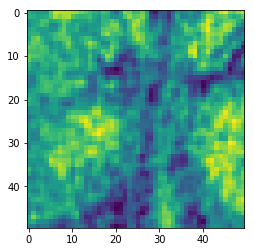

In [103]:
plt.imshow(test)

In [112]:
pancreas_threadshold

1800